# 로이터 뉴스 기사 다중 분류 문제



In [18]:
from tensorflow.keras.datasets import reuters
import numpy as np
from tensorflow.keras import layers
from tensorflow import keras

In [5]:
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words = 10000)

print(len(train_data), len(test_data)) # 8982, 2246
print(train_data[10]) # 정수로 된 리스트


8982 2246
[1, 245, 273, 207, 156, 53, 74, 160, 26, 14, 46, 296, 26, 39, 74, 2979, 3554, 14, 46, 4689, 4329, 86, 61, 3499, 4795, 14, 61, 451, 4329, 17, 12]
550378/550378 [==============================] - 0s 0us/step


In [6]:
# 단어 디코딩 - 안해도 무방함
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_newswire = " ".join([reverse_word_index.get(i - 3, "?") for i in train_data[0]])
print(decoded_newswire)

? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


### 데이터 준비
- 데이터셋은 전체 데이터셋에 대해 각 단어에 인덱스를 부여했음
- 일반적으로는 훈련 데이터셋에 대해서만 어휘 사전이 구축됨. 왜냐하면 테스트 세트의 어휘를 이용하면 낙관적으로 테스트 세트를 평가하는 것이기 때문.

In [10]:
def vectorize_sequences(sequences, dimension = 10000):
  results = np.zeros((len(sequences), dimension)) # (리뷰 갯수, 단어 갯수)의 크기를 가지면서 모든 값 0
  for i, sequence in enumerate(sequences):
    for j in sequence:
      results[i, j] = 1. # 특정 인덱스의 위치만 1로 만듦

In [13]:
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

### 인코딩
- 레이블 -> 벡터 변환 방법은 2가지이다.
1. 레이블 리스트 -> 정수 텐서 변환
2. 원-핫 인코딩 (범주형 인코딩)

In [23]:
# 원핫인코딩 예시
def to_one_hot(labels, dimension = 46):
  results = np.zeros((len(labels), dimension))
  for i, label in enumerate(labels):
      results[i, label] = 1.
  return results

x_train = to_one_hot(train_labels)
x_test = to_one_hot(test_labels)

In [41]:
# 케라스의 내장 함수(원핫인코딩)
from keras.utils.np_utils import to_categorical

y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)


In [47]:
print(train_labels)

[ 3  4  3 ... 25  3 25]


In [46]:
print(y_train[0])
print(y_test)

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### 모델 구성
- 인풋은 짧은 텍스트로 이전과 동일
- 아웃풋은 2개 -> 46개가 되었음
- 이전 모델은 유닛은 16개만 썼지만, 46개를 분류하기엔 제약이 많아 보여서 유닛을 64개로 구성함

In [21]:
model = keras.Sequential([
 layers.Dense(64, activation = 'relu'),
 layers.Dense(64, activation = 'relu'),
 layers.Dense(46, activation = 'softmax')
])

model.compile(optimizer = 'rmsprop',
              loss = 'categorical_crossentropy', # binary -> 다중범주니까 바뀜. 두 확률 분포 사이의 거리를 측정하며 이를 최소화함
              metrics = ['accuracy'])

In [26]:
# 훈련 & 검증

x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = y_train[:1000]
partial_y_train = y_train[1000:]

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs = 20,
                    batch_size = 512,
                    validation_data = (x_val, y_val))


Epoch 1/20
16/16 [==============================] - 1s 23ms/step - loss: 3.5923 - accuracy: 0.4870 - val_loss: 3.3223 - val_accuracy: 0.6820
Epoch 2/20
16/16 [==============================] - 0s 9ms/step - loss: 3.0648 - accuracy: 0.6421 - val_loss: 2.7119 - val_accuracy: 0.6350
Epoch 3/20
16/16 [==============================] - 0s 7ms/step - loss: 2.3924 - accuracy: 0.6556 - val_loss: 1.9898 - val_accuracy: 0.6820
Epoch 4/20
16/16 [==============================] - 0s 8ms/step - loss: 1.7204 - accuracy: 0.6942 - val_loss: 1.4261 - val_accuracy: 0.7280
Epoch 5/20
16/16 [==============================] - 0s 8ms/step - loss: 1.2791 - accuracy: 0.7502 - val_loss: 1.1066 - val_accuracy: 0.7720
Epoch 6/20
16/16 [==============================] - 0s 9ms/step - loss: 1.0186 - accuracy: 0.7725 - val_loss: 0.8980 - val_accuracy: 0.7970
Epoch 7/20
16/16 [==============================] - 0s 7ms/step - loss: 0.8334 - accuracy: 0.8176 - val_loss: 0.7378 - val_accuracy: 0.8650
Epoch 8/20
16/16 [=

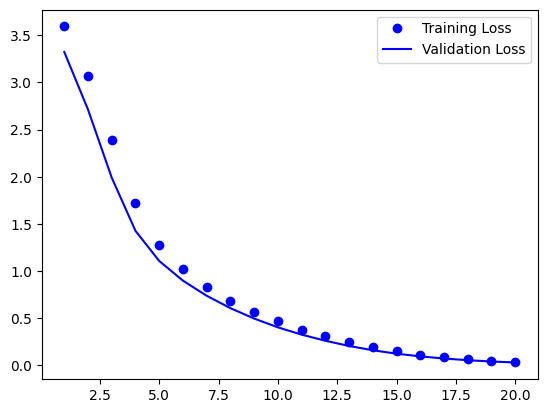

In [27]:
# 시각화
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label = "Training Loss")
plt.plot(epochs, val_loss_values, "b", label = "Validation Loss")
plt.legend()
plt.show()

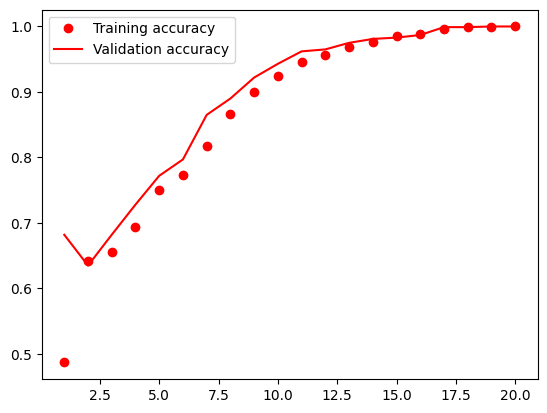

In [29]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
plt.plot(epochs, acc, "ro", label = "Training accuracy")
plt.plot(epochs, val_acc, "r", label = "Validation accuracy")
plt.legend()
plt.show()

In [30]:
# 책은 재훈련하고 테스트를 하지만 나는 딱히 과대적합이 나오지 않았기 때문에 바로 평가를 해본다
results = model.evaluate(x_test, y_test)

71/71 [==============================] - 1s 7ms/step - loss: 0.0336 - accuracy: 1.0000


In [32]:
print(results)

[0.03363821282982826, 1.0]


### 랜덤 분류기와 성능 비교하기

In [33]:
import copy
test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy) # copy버전은 섞음
hist_array = np.array(test_labels) == np.array(test_labels_copy)
hist_array.mean()

0.1772039180765806

### 새로운 데이터 예측하기

In [34]:
predictions = model.predict(x_test)


71/71 [==============================] - 0s 1ms/step


In [36]:
predictions.shape # 각 벡터는 46개의 원소로 이뤄졌으며, 모든 원소의 합은 1이다. 각 원소는 해당 인덱스일 확률을 나타냄.
np.argmax(predictions[0]) # np.argmax 자주 쓰니까 참고, 3번 인덱스로 분류한단다

3

### 인코딩하는 다른 방법 : 리스트를 정수 텐서로 바꾸기

- 이전에 사용한 원핫인코딩은 각 범주를 범주 갯수 길이의 텐서로 만든 다음, 해당하는 범주만 1로 표시하는 방식이었음
> ex) 3개중 3번째 범주면 [0 0 1]
- 여기서 사용하는 방법은 각 범주의 값을 유지하는 형태임
> ex) 3개 중 3번째 범주면 2

In [48]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

In [49]:
print(y_train)

[ 3  4  3 ... 25  3 25]


In [50]:
# 이 경우, 손실함수를 `sparse_categorical_crossentropy` 로 바꿔준다. 적용되는 알고리즘은 동일하나 인풋의 형태 때문에 다르게 사용하는 것 뿐임